In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
query_path = "../results/query_squat"
results_rep_1_df = pd.read_csv(os.path.join(query_path, "rep_1/results.csv")).pivot(index='frame', columns='angle_name', values='diff')
results_rep_2_df = pd.read_csv(os.path.join(query_path, "rep_2/results.csv")).pivot(index='frame', columns='angle_name', values='diff')
results_rep_3_df = pd.read_csv(os.path.join(query_path, "rep_3/results.csv")).pivot(index='frame', columns='angle_name', values='diff')
results_rep_4_df = pd.read_csv(os.path.join(query_path, "rep_4/results.csv")).pivot(index='frame', columns='angle_name', values='diff')

## Differences visualisation

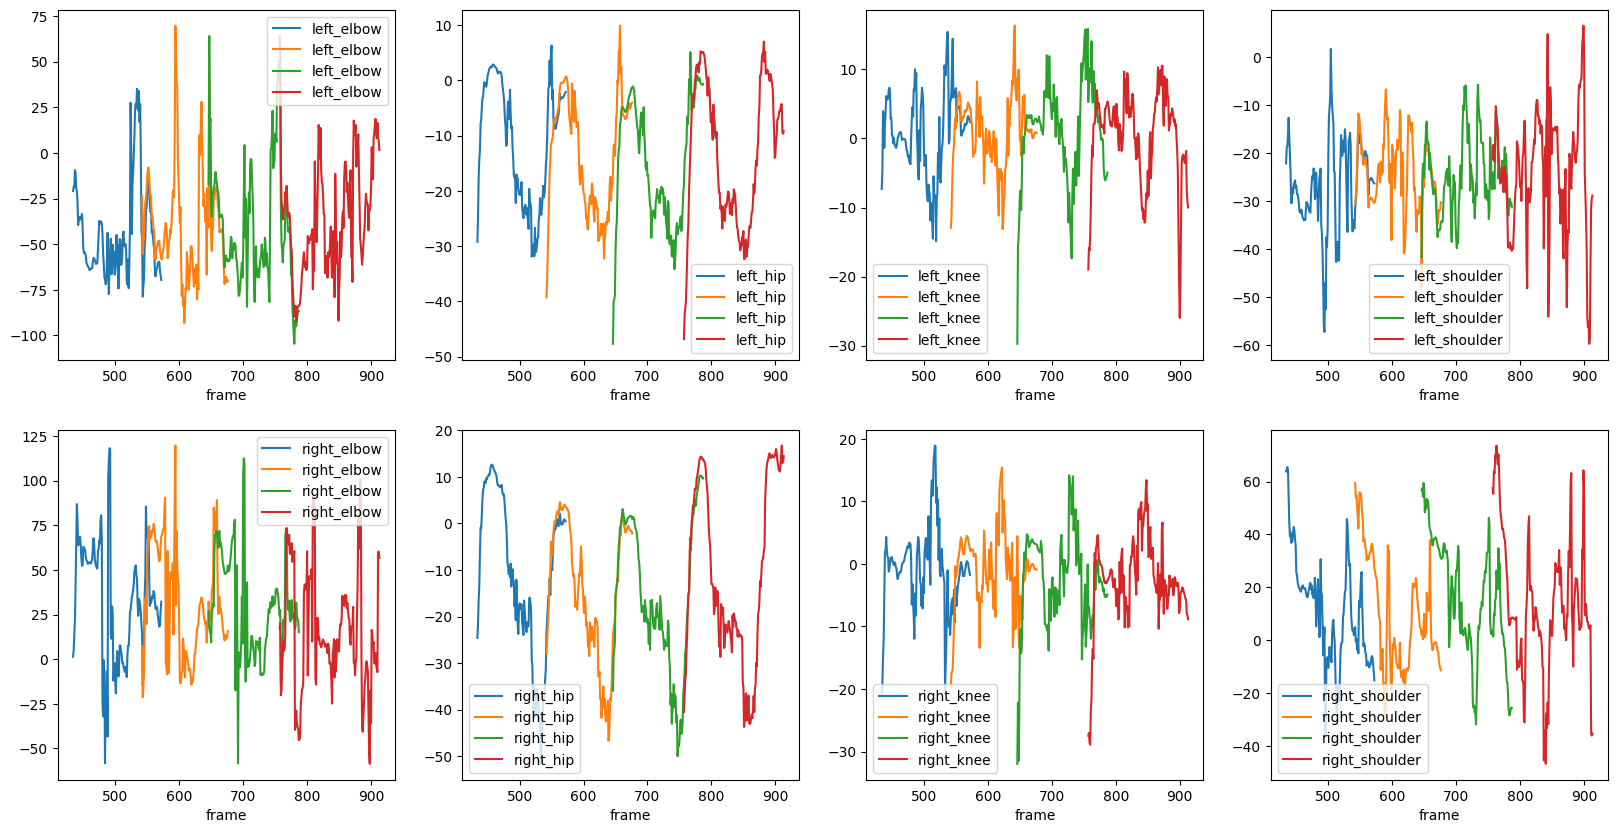

In [3]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
columns = results_rep_1_df.columns
results_df = [results_rep_1_df, results_rep_2_df, results_rep_3_df, results_rep_4_df]

for col, ax in zip(columns, axes.flatten()):
    for df in results_df:
        df.plot(y=col, ax=ax)

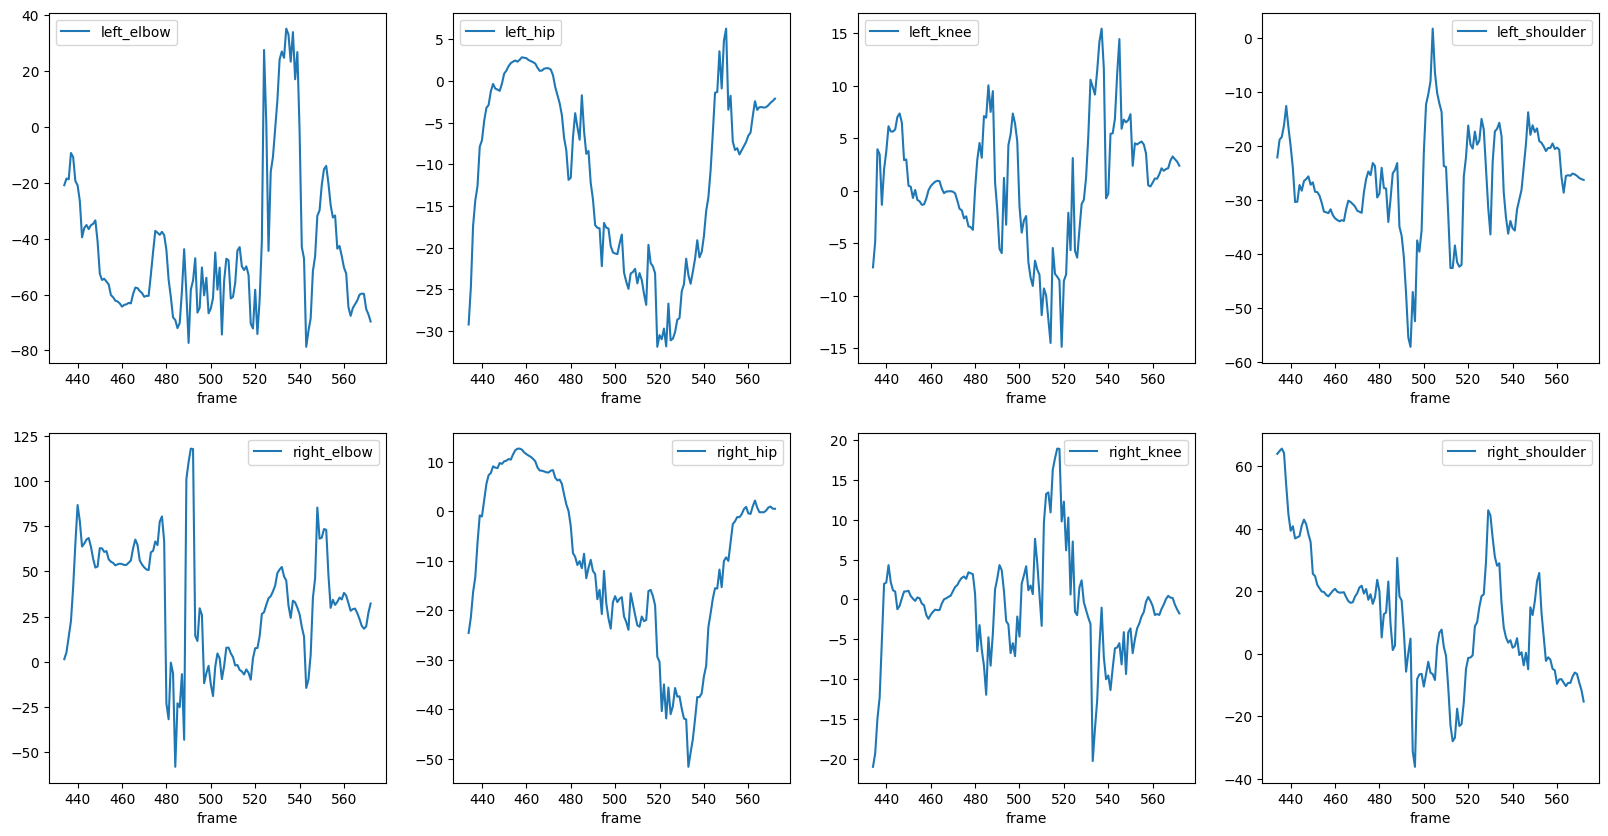

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for col, ax in zip(columns, axes.flatten()):
    results_rep_1_df.plot(y=col, ax=ax)

## Angles comparison

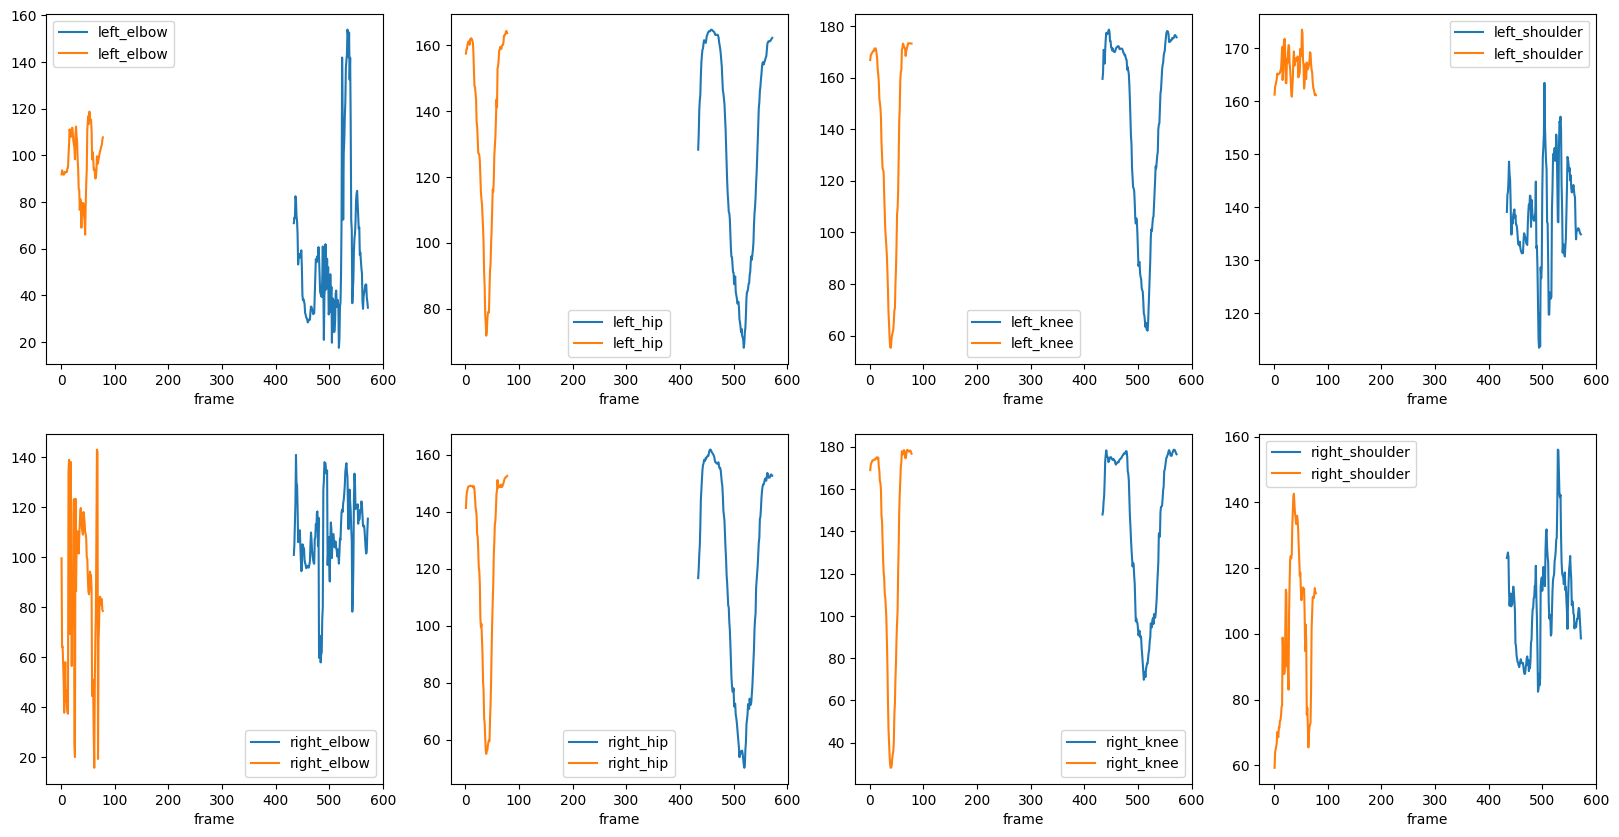

In [5]:
reference_angles = pd.read_csv('../data/squat/features/reference/angles.csv').pivot(
            index="frame", columns="name", values="value"
        )

query_angles = pd.read_csv(os.path.join(query_path, 'rep_1/angles.csv')).pivot(
            index="frame", columns="name", values="value"
        )

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for col, ax in zip(columns, axes.flatten()):
    query_angles.plot(y=col, ax=ax)
    reference_angles.plot(y=col, ax=ax)


## Video comparison visualization

In [6]:
import matplotlib.animation as animation
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def animate(frames):
    fig = plt.figure()
    ims = []
    for img in frames:
        ims.append([plt.imshow(img, animated=True)])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.close()
    return ani

def get_frames(cap, frame_indexes: list):
    frames = []
    for frame_idx in frame_indexes:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    return frames

def skip_n_frames(cap, n):
    for _ in range(n):
        cap.read()

def filter(signal: np.ndarray, fps = 10) -> np.ndarray:
    cutoff_freq = fps
    kernel = np.ones(cutoff_freq) / cutoff_freq
    filtered_signal = np.convolve(signal, kernel, mode="same")
    return filtered_signal


def get_exercise_signal(data : pd.DataFrame, signal_features: int = 1):
        data = data.pivot(
            index="frame", columns="name", values="value"
        )
        scaler = MinMaxScaler()
        important_features = (
            data.std()
            .sort_values(ascending=False)[
                : signal_features
            ]
            .keys()
        )
        important_angles_df = data[['left_knee']]
        important_angles_normalized = scaler.fit_transform(important_angles_df)
        signal = important_angles_df.mean(axis=1)
        return filter(signal)

def filter_repetable_reference_indexes(
    referene_to_query: np.ndarray, query_to_refernce: np.ndarray
) -> np.ndarray:
    query_to_refernce_cp = query_to_refernce.copy()

    for idx in range(len(referene_to_query) - 1, -1, -1):
        if idx > 0 and referene_to_query[idx] == referene_to_query[idx - 1]:
            query_to_refernce_cp = np.delete(query_to_refernce_cp, idx)

    return query_to_refernce_cp


In [7]:
reference_cap = cv2.VideoCapture('../data/squat/videos/reference_squat.mp4')
query_cap = cv2.VideoCapture("/Users/hubert/Downloads/przysiad.mp4")

In [8]:
query_signal = get_exercise_signal(pd.read_csv(os.path.join(query_path, 'rep_1/angles.csv')))
reference_signal = get_exercise_signal(pd.read_csv('../data/squat/features/reference/angles.csv'))

In [9]:
from dtw import dtw

alignment = dtw(query_signal, reference_signal, keep_internals=True)
reference_to_query_warped = alignment.index1
query_to_refernce_warped = alignment.index2

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [10]:
reference_frames_indexes = filter_repetable_reference_indexes(reference_to_query_warped, query_to_refernce_warped)

In [20]:
from IPython.display import HTML
import base64

mp4 = open("/tmp/video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
HTML(
    """<video width=600 controls>
      <source src="%s" type="video/mp4"></video>
  """
    % data_url
)

In [12]:
query_frames = get_frames(query_cap, np.arange(results_rep_1_df.index[0], results_rep_1_df.index[-1] + 1, 1))
reference_frames = get_frames(reference_cap, reference_frames_indexes)

In [13]:
height, width = query_frames[0].shape[:2]

resized_reference_frames = []
for frame in reference_frames:
    resized_frame = cv2.resize(frame, (width, height))
    resized_reference_frames.append(resized_frame)

In [14]:
zipped_frames = np.concatenate((query_frames, resized_reference_frames), axis=2)
ani = animate(zipped_frames[..., ::-1])
ani.save(f"/tmp/video.mp4", writer="ffmpeg") 

In [15]:
from IPython.display import HTML
import base64

mp4 = open("/tmp/video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
HTML(
    """<video width=600 controls>
      <source src="%s" type="video/mp4"></video>
  """
    % data_url
)

## Joints comparison visualization

In [16]:
reference_joints = pd.read_csv('../data/squat/features/reference/joints.csv')
query_joints = pd.read_csv(os.path.join(query_path, 'rep_1/joints.csv'))

In [17]:
import yaml

X_LIM = (-1, 1)
Y_LIM = (-1, 1)
Z_LIM = (-1, 1)

ELEV = -90
AZIM = -90

with open('../configs/config.yaml') as config_file:
    connections = yaml.safe_load(config_file)['mediapipe']['connections']['torso']

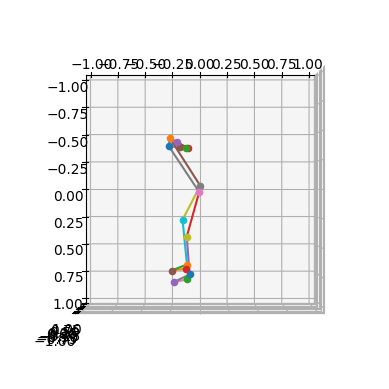

In [18]:
def get_3D_animation(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    def update(i):
        ax.clear()
        ax.set_xlim3d(*X_LIM)
        ax.set_ylim3d(*Y_LIM)
        ax.set_zlim3d(*Z_LIM)
        ax.view_init(elev=ELEV, azim=AZIM)

        frame_data = data[data['frame'] == i]
        for _, row in frame_data.iterrows():
            ax.scatter3D(row['x'], row['y'], row['z'])

        for connection in connections:
            if frame_data[frame_data['id'] == connection[0]].empty or frame_data[frame_data['id'] == connection[1]].empty:
                continue
            ax.plot(
                [frame_data[frame_data['id'] == connection[0]]['x'].values[0], frame_data[frame_data['id'] == connection[1]]['x'].values[0]],
                [frame_data[frame_data['id'] == connection[0]]['y'].values[0], frame_data[frame_data['id'] == connection[1]]['y'].values[0]],
                [frame_data[frame_data['id'] == connection[0]]['z'].values[0], frame_data[frame_data['id'] == connection[1]]['z'].values[0]],
            )

    return animation.FuncAnimation(fig, update, frames=pd.unique(data['frame']), interval=120)

ani = get_3D_animation(query_joints)
HTML(ani.to_jshtml())

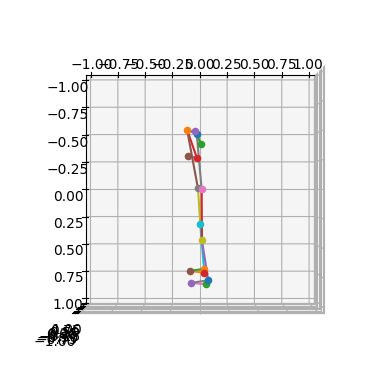

In [19]:
ani = get_3D_animation(reference_joints)
HTML(ani.to_jshtml())